DENOISING ALGORITHM - FIRST METHOD 

In [245]:
import numpy as np
import pywt
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
from scipy.linalg import svd
from scipy.ndimage.filters import maximum_filter
import matplotlib.pyplot as plt
import sys
import statistics 
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks, savgol_filter

C:\Users\chiar\AppData\Local\Temp\ipykernel_67944\3245297691.py:6: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter


In [279]:
# List function 

def base_deriv(s0):
    """
    Function to determine signal derivative
    Uses equation 5 of Zorin et. al. Magn. Reson. Chem. 2017, 55, 738–746
    
    Parameters
    ----------
    s0  : ndarray
        The real component of a FFT array
    Returns
    -------
    deriv : ndarray
        The derivitive of the data, s0
    """
    deriv = np.zeros((len(s0)))
    for i in range(5,len(s0)-5):
        deriv[i] = (42*(s0[i] - s0[i-1]) + 48*(s0[i+1]-s0[i-2]) + 27*(s0[i+2]-s0[i-3]) + 8*(s0[i+3]-s0[i-4]) + s0[i+4]-s0[i-5])/512
    return deriv

# Signal Region Identifcation 
def signal_region(data, k):

    # Percentage of noise
    np_percentage = 10
    np_sample = round(len(data) * (np_percentage / 100))
    
    # Calculate mean and standard deviation of noise
    mean_noise = np.mean(np.abs(np.real(data[:np_sample])))
    std_noise = np.std(np.real(data[:np_sample]))
    
    # Threshold for noise
    threshold_noise = mean_noise + k * std_noise
    
    # Find indices where data is above threshold (potential signal)
    ind_over = np.where(data> threshold_noise)[0]
    
    # Find consecutive ranges containing signal
    # over = consecutive(ind_over, stepsize=1)
    # temp = np.diff(ind_over)
    # temp2 = np.where(temp == 1)
    # over = ind_over[temp2]  # Range containing the signal
    # first_last = [over[n] for n in (0,-1)]  
    
    return ind_over,threshold_noise
    # return ind_over

def find_peak_region(signal,threshold_noise):
    map = np.zeros(len(signal))
    for i in range(0, len(signal)): 
        if signal[i]>threshold_noise: 
            map[i]=1

    for i in range(0,len(map)): 
        # map2 = np.zeros(len(map))
        if map[i]==0 and map[i-1]==1: 
            k = i 
            count = 0 
            try:

                while map[k]==0 and k < len(map)-1: 
                    count = count+1
                    if k < len(map)-1:
                        k =k+1 
                   
                if count <20:
                    map[i:k]=1
            except:
                print("Error")
                

    return map

# consecutive number in an array

def consecutive(data, stepsize=1):
    """"
    basic function to blocks of consecutive number in an array
    """
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def analyze_peaks(signal, threshold,distance):
    x = np.arange(1, len(signal) + 1)
    y = np.real(signal)

    # get derivatives
    dy = np.diff(y)
    dx = np.diff(x)
    dy_dx = np.concatenate(([0], dy / dx))

    # get peaks with width computed by 'findpeaks'
    # smooth = gaussian_filter1d(y, 1)
    locs, prop = find_peaks(y, height=threshold, distance = distance ,prominence=True, width=True)

    pks = prop['peak_heights']
    p = prop['prominences']
    peakWidth1 = prop['width_heights']
    
    # compute starting and ending points
    startpoint = np.zeros_like(pks)
    endpoint = np.zeros_like(pks)

    for ii in range(len(pks)):
        sp = np.where((x < locs[ii]) & (dy_dx > 0))
        if np.shape(sp) == 0:
            sp = 0
        else:
            sp=sp[0][-1]
        startpoint[ii] = sp

        ep = np.where((x > locs[ii]) & (dy_dx >= 0))
        if np.shape(ep)==0:
            ep = len(x)
        else:
            ep=ep[0][0]
        endpoint[ii] = ep+1

    # compute second type of width using ending and starting points
    PeakWidth2 = []
    PeakWidth2 = [x[int(endpoint[i])] - x[int(startpoint[i])] for i in range(len(endpoint))]
   

    # structure creation containing information about peaks
    PeakInfo = []
    for PeakNum in range(len(locs)):
        if np.shape(locs[PeakNum]) == 0:
            PeakInfo.append({
                'Start': 0, 'End': 0, 'Index': 0,
                'Val': 0, 'PeakWidth': 0
            })
        else:
            PeakInfo.append({
                'Start': startpoint[PeakNum], 'End': endpoint[PeakNum], 'Index': locs[PeakNum],
                'Val': pks[PeakNum], 'PeakWidth': PeakWidth2[PeakNum]
            })

    
    return PeakInfo

def process_blocks(map, noisy_sgn,th, buff_size):

    fig, ax = plt.subplots(dpi=130, figsize=(8,3))
    ax.plot(np.real(noisy_sgn)/max(noisy_sgn), linewidth=0.5)
    
    map0 = np.copy(map)
    ind = np.where(map0 == 1)[0]
    cons = consecutive(ind, stepsize=1)  # it contains our box in which should be the signal 

    for ii in range(len(cons)): 
        startblock = cons[ii][0] - buff_size
        endblock = cons[ii][-1] + buff_size
        block_sgn = noisy_sgn[startblock:endblock]              # signal inside the block
        
        blockInfo = analyze_peaks(block_sgn, th, distance = 10) # list peak in the block

        # check if there are not peaks into the block 
        if not blockInfo:
            map0[startblock:endblock] = 0 

       
        # check how many peaks there are inside one block, if there are more than 1 peak, check if these are overlapped 
        if len(blockInfo) != 1: 
            num_peak_block = len(blockInfo)                         # number peaks in the block  
            # smooth = gaussian_filter1d(block_sgn, 1)
            smooth = block_sgn

            # find the inflaction point such as the minimum value between the two consecutive peaks
            ip_index_storage = np.zeros(num_peak_block-1)
            ip_bool =  np.zeros(num_peak_block-1)

            for j in range(0,num_peak_block-1):        
                previous_peak = blockInfo[j]["Index"]
                antecedent_peak = blockInfo[j+1]["Index"]
                ip_index = int(np.argmin(smooth[previous_peak:antecedent_peak])+previous_peak)
                ip_index_storage[j] = ip_index
                if block_sgn[ip_index]< th: 
                    ip_bool [j] = 1
                else: 
                    ip_bool [j] = 0

            # if len(ip_index) == 1: # there are only two peaks in the block 
            if sum(ip_bool) != 0: # i.p. is in the noise, let's apply function 
                for NumPeak in range(0, len(blockInfo) - 1): 
                        if NumPeak != len(blockInfo):
                            start_noise = blockInfo[NumPeak]['End'] + startblock + 5
                            end_noise = blockInfo[NumPeak + 1]['Start'] + startblock - 5

                            start_noise = int(start_noise)
                            end_noise = int(end_noise)

                            start_signal = int(blockInfo[NumPeak]['Start']+startblock)
                            end_signal = int(blockInfo[NumPeak]['End']+startblock)

                            map0[start_noise:end_noise] = 0
                            map0[start_signal:end_signal] = 1
            else: # i.p. is over the noise, let's separate the peaks 
                for NumInflePoint in range(0, len(blockInfo) - 1): 
                    zero_point= int(ip_index_storage[NumInflePoint]+startblock)
                    

                    map0[zero_point] = 0
    
    ax.plot(map0, linewidth=0.5)                         
    return map0

# extraction block info 
def BlockInfo(map):
    map0 = np.copy(new_map)
    ind = np.where(map0 == 1)[0]
    cons = consecutive(ind, stepsize=1)  # it contains our box in which should be the signal 

    BlockInfo = []
    for BlockNum in range(len(cons)): 
        BlockInfo.append({
            'Start' :  cons[BlockNum][0], 'End' : cons[BlockNum][-1]
        })
        
    return BlockInfo


In [258]:
#!/usr/bin/env python3
# −*− coding:utf-8 −*−

import numpy as np
from scipy.linalg import svd


class Denoiser(object):
    '''
    A class for smoothing a noisy, real-valued data sequence by means of SVD of a partial circulant matrix.
    -----
    Attributes:
        mode: str
            Code running mode: "layman" or "expert".
            In the "layman" mode, the code autonomously tries to find the optimal denoised sequence.
            In the "expert" mode, a user has full control over it.
        s: 1D array of floats
            Singular values ordered decreasingly.
        U: 2D array of floats
            A set of left singular vectors as the columns.
        r: int
            Rank of the approximating matrix of the constructed partial circulant matrix from the sequence.
    '''

    def __init__(self, mode="layman"):
        '''
        Class initialization.
        -----
        Arguments:
            mode: str
                Denoising mode. To be selected from ["layman", "expert"]. Default is "layman".
                While "layman" grants the code autonomy, "expert" allows a user to experiment.
        -----
        Raises:
            ValueError
                If mode is neither "layman" nor "expert".
        '''
        self._method = {"layman": self._denoise_for_layman, "expert": self._denoise_for_expert}
        if mode not in self._method:
            raise ValueError("unknown mode '{:s}'!".format(mode))
        self.mode = mode

    def _embed(self, x, m): # 1) embeded the sequence into a matrix
        '''
        Embed a 1D array into a 2D partial circulant matrix by cyclic left-shift.
        -----
        Arguments:
            x: 1D array of floats
                Input array.
            m: int
                Number of rows of the constructed matrix.
        -----
        Returns:
            X: 2D array of floats
                Constructed partial circulant matrix.
        '''
        x_ext = np.hstack((x, x[:m-1]))
        shape = (m, x.size)
        strides = (x_ext.strides[0], x_ext.strides[0])
        X = np.lib.stride_tricks.as_strided(x_ext, shape, strides)
        return X

    def _reduce(self, A): # 7) application equation (10) -> cyclic antidiagonal averaging is applied to reconstruct the smoothed sequence a from A
        '''
        Reduce a 2D matrix to a 1D array by cyclic anti-diagonal average.
        -----
        Arguments:
            A: 2D array of floats
                Input matrix.
        -----
        Returns:
            a: 1D array of floats
                Output array.
        '''
        m = A.shape[0]
        A_ext = np.hstack((A[:,-m+1:], A))
        strides = (A_ext.strides[0]-A_ext.strides[1], A_ext.strides[1])
        a = np.mean(np.lib.stride_tricks.as_strided(A_ext[:,m-1:], A.shape, strides), axis=0)
        return a

    def _denoise_for_expert(self, sequence, layer, gap, rank):
        '''
        Smooth a noisy sequence by means of low-rank approximation of its corresponding partial circulant matrix.
        -----
        Arguments:
            sequence: 1D array of floats
                Data sequence to be denoised.
            layer: int
                Number of leading rows selected from the matrix.
            gap: float
                Gap between the data levels on the left and right ends of the sequence.
                A positive value means the right level is higher.
            rank: int
                Rank of the approximating matrix.
        -----
        Returns:
            denoised: 1D array of floats
                Smoothed sequence after denoise.
        -----
        Raises:
            AssertionError
                If condition 1 <= rank <= layer <= sequence.size cannot be fulfilled.
        '''
        assert 1 <= rank <= layer <= sequence.size
        self.r = rank
        # linear trend to be deducted
        trend = np.linspace(0, gap, sequence.size)
        X = self._embed(sequence-trend, layer)
        # singular value decomposition
        self.U, self.s, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)
        # low-rank approximation
        A = self.U[:,:self.r] @ np.diag(self.s[:self.r]) @ Vh[:self.r]
        denoised = self._reduce(A) + trend
        return denoised

    def _cross_validate(self, x, m):
        '''
        Check if the gap of boundary levels of the detrended sequence is within the estimated noise strength.
        -----
        Arguments:
            x: 1D array of floats
                Input array.
            m: int
                Number of rows of the constructed matrix.
        -----
        Returns:
            valid: bool
                Result of cross validation. True means the detrending procedure is valid.
        '''
        X = self._embed(x, m)
        self.U, self.s, self._Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False) # 2) apply SVD to X
        # Search for noise components using the normalized mean total variation of the left singular vectors as an indicator.
        # The procedure runs in batch of every 10 singular vectors.
        self.r = 0
        while True: # means that the loop will continue indefinitely until the break statement is encountered, which terminates the loop.
            U_sub = self.U[:,self.r:self.r+10]
            NMTV = np.mean(np.abs(np.diff(U_sub,axis=0)), axis=0) / (np.amax(U_sub,axis=0) - np.amin(U_sub,axis=0)) # 3) calculate the NMTVs
            try:
                # the threshold of 10% can in most cases discriminate noise components
                self.r += np.argwhere(NMTV > .1)[0,0]
                break
            except IndexError:
                self.r += 10
        # estimate the noise strength, while r marks the first noise component
        noise_stdev = np.sqrt(np.sum(self.s[self.r:]**2) / X.size)
        # estimate the gap of boundary levels after detrend
        gap = np.abs(x[-self._k:].mean()-x[:self._k].mean()) # 4) estimate the signal gap by averaging a few end-data in x
        valid = gap < noise_stdev  # if noise:stdev is smaller than delta, linearly detrend x, then repeat steps 2-4, otherwhise proceed
        return valid

    def _denoise_for_layman(self, sequence, layer):
        '''
        Similar to the "expert" method, except that denoising parameters are optimized autonomously.
        -----
        Arguments:
            sequence: 1D array of floats
                Data sequence to be denoised.
            layer: int
                Number of leading rows selected from the corresponding circulant matrix.
        -----
        Returns:
            denoised: 1D array of floats
                Smoothed sequence after denoise.
        -----
        Raises:
            AssertionError
                If condition 1 <= layer <= sequence.size cannot be fulfilled.
        '''
        assert 1 <= layer <= sequence.size

        # The assertion statement is asserting that layer should be within the range of 1 to the size of the sequence 
        # object (sequence.size). If the condition is not met, an AssertionError exception will be raised, indicating
        # that the condition failed.

        # The code takes the mean of a few neighboring data to estimate the boundary levels of the sequence.
        # By default, this number is 11.
        self._k = 11
        # Initially, the code assumes no linear inclination.
        trend = np.zeros_like(sequence)
        # Iterate over the averaging length.
        # In the worst case, iteration must terminate when it is 1.
        while not self._cross_validate(sequence-trend, layer):
            self._k -= 2
            trend = np.linspace(0, sequence[-self._k:].mean()-sequence[:self._k].mean(), sequence.size)
        # low-rank approximation by using only signal components
        A = self.U[:,:self.r] @ np.diag(self.s[:self.r]) @ self._Vh[:self.r] # 6) build a low rank approximation A 
        denoised = self._reduce(A) + trend
        return denoised

    def denoise(self, *args, **kwargs):
        '''
        User interface method.
        It will reference to different denoising methods ad hoc under the fixed name.
        '''
        return self._method[self.mode](*args, **kwargs)



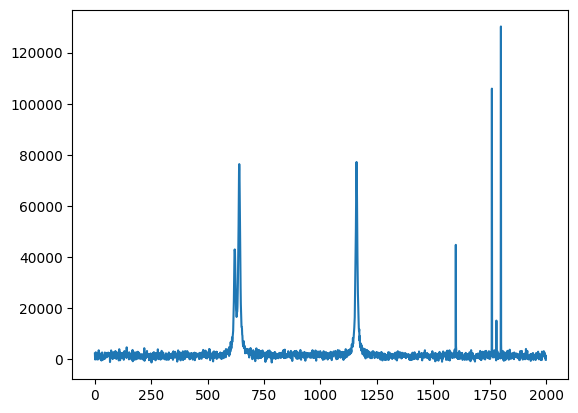

In [141]:
# Sinteti Data 


# Data generation 
t = np.arange(0, 2, 0.001)

fid1 = 100*np.exp(-t / 2.1) * np.cos(2 * np.pi * -100 * t) + 100*1j*np.exp(-t / 2.1) * np.sin(2 * np.pi * -100 * t)
fid2 = 10*np.exp(-t / 2.1) * np.cos(2 * np.pi * -110 * t) + 10*1j*np.exp(-t / 2.1) * np.sin(2 * np.pi * -110 * t)
fid9 =  80*np.exp(-t / 2.1) * np.cos(2 * np.pi * -120 * t) + 80*1j*np.exp(-t / 2.1) * np.sin(2 * np.pi * -120 * t)
# fid2 = 1000*np.exp(-t / 0.01) * np.cos(2 * np.pi * -800 * t) + 1000*1j*np.exp(-t / 0.01) * np.sin(2 * np.pi * -800 * t)
fid3 = 500*np.exp(-t / 0.08) * np.cos(2 * np.pi * 310 * t) + 500*1j*np.exp(-t / 0.08) * np.sin(2 * np.pi * 310 * t)
fid4 = +1000*np.exp(-t / 0.075) * np.cos(2 * np.pi * 320* t) + 1000*1j*np.exp(-t / 0.075) * np.sin(2 * np.pi * 320 * t)

fid5 = +50*np.exp(-t / 1) * np.cos(2 * np.pi * -200 * t) + 50*1j*np.exp(-t / 1) * np.sin(2 * np.pi * -200 * t)
fid6 = 1000*np.exp(-t / 0.075) * np.cos(2 * np.pi * -420* t) + 1000*1j*np.exp(-t / 0.075) * np.sin(2 * np.pi * -420 * t)


fid = fid1+fid2+fid3+fid4+fid5+fid6+fid9

dt = t[2] - t[1] 
N = len(fid)
freqs = fftfreq(N, dt)

pure = np.real(fft(fid))
noise = np.random.normal(0,  300, len(pure))  # Generation Gaussian noise

signal = pure + 3*noise          # Application noise to the pure sample
plt.plot(signal)

In [18]:
import matplotlib.animation as animation
from ipywidgets import interact, widgets, fixed, interactive, HBox, Layout
import os

In [ ]:
# load data 
import scipy.io
directory ='C:/Users/chiar/Documents/tesi IBEC doc/script/FinalFolder/'
signal = scipy.io.loadmat(directory+ 'signal.mat')
signal = signal['signal'][0]
plt.plot(signal)

Text(0.5, 1.0, 'Region Signal Detection')

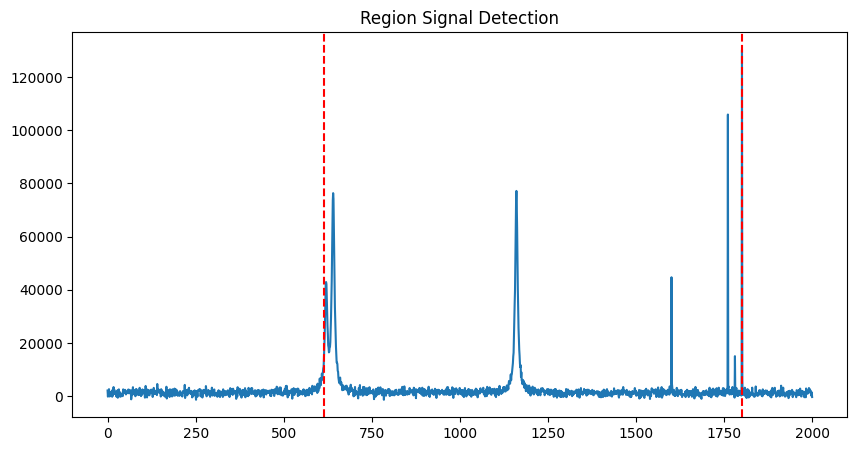

In [259]:
regionSgn, threshold_noise =  signal_region(signal,10)
plt.figure(figsize=(10, 5))  # Imposta la dimensione della figura

# Primo subplot
plt.plot(signal)
plt.axvline(x=regionSgn[0], color='r', linestyle='--')
plt.axvline(x=regionSgn[-1], color='r', linestyle='--')
plt.title('Region Signal Detection')

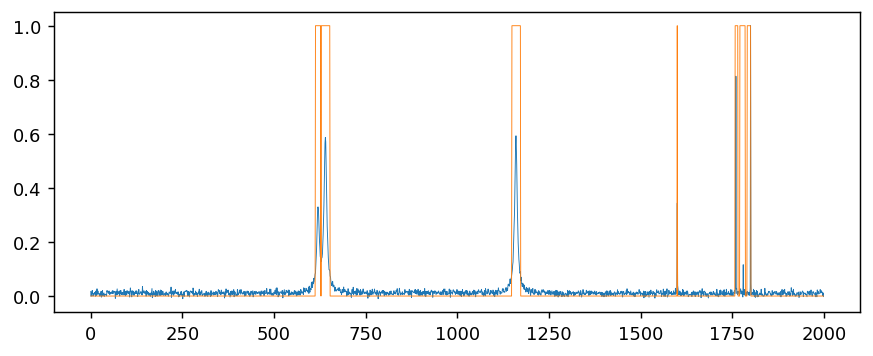

In [262]:
# function application 
regionSgn, threshold_noise =  signal_region(signal,10)
first_map = find_peak_region(signal,threshold_noise)
PeakInfo = analyze_peaks(signal, threshold_noise, distance=30)
new_map= process_blocks(first_map, signal, threshold_noise, buff_size=5)
InfoBlock = BlockInfo(new_map)

In [263]:
InfoBlock

[{'Start': 613, 'End': 627},
 {'Start': 629, 'End': 652},
 {'Start': 1149, 'End': 1172},
 {'Start': 1600, 'End': 1600},
 {'Start': 1758, 'End': 1765},
 {'Start': 1771, 'End': 1785},
 {'Start': 1791, 'End': 1800}]

In [264]:
PeakVal = [PeakInfo[i]['Val'] for i in range(len(PeakInfo))]

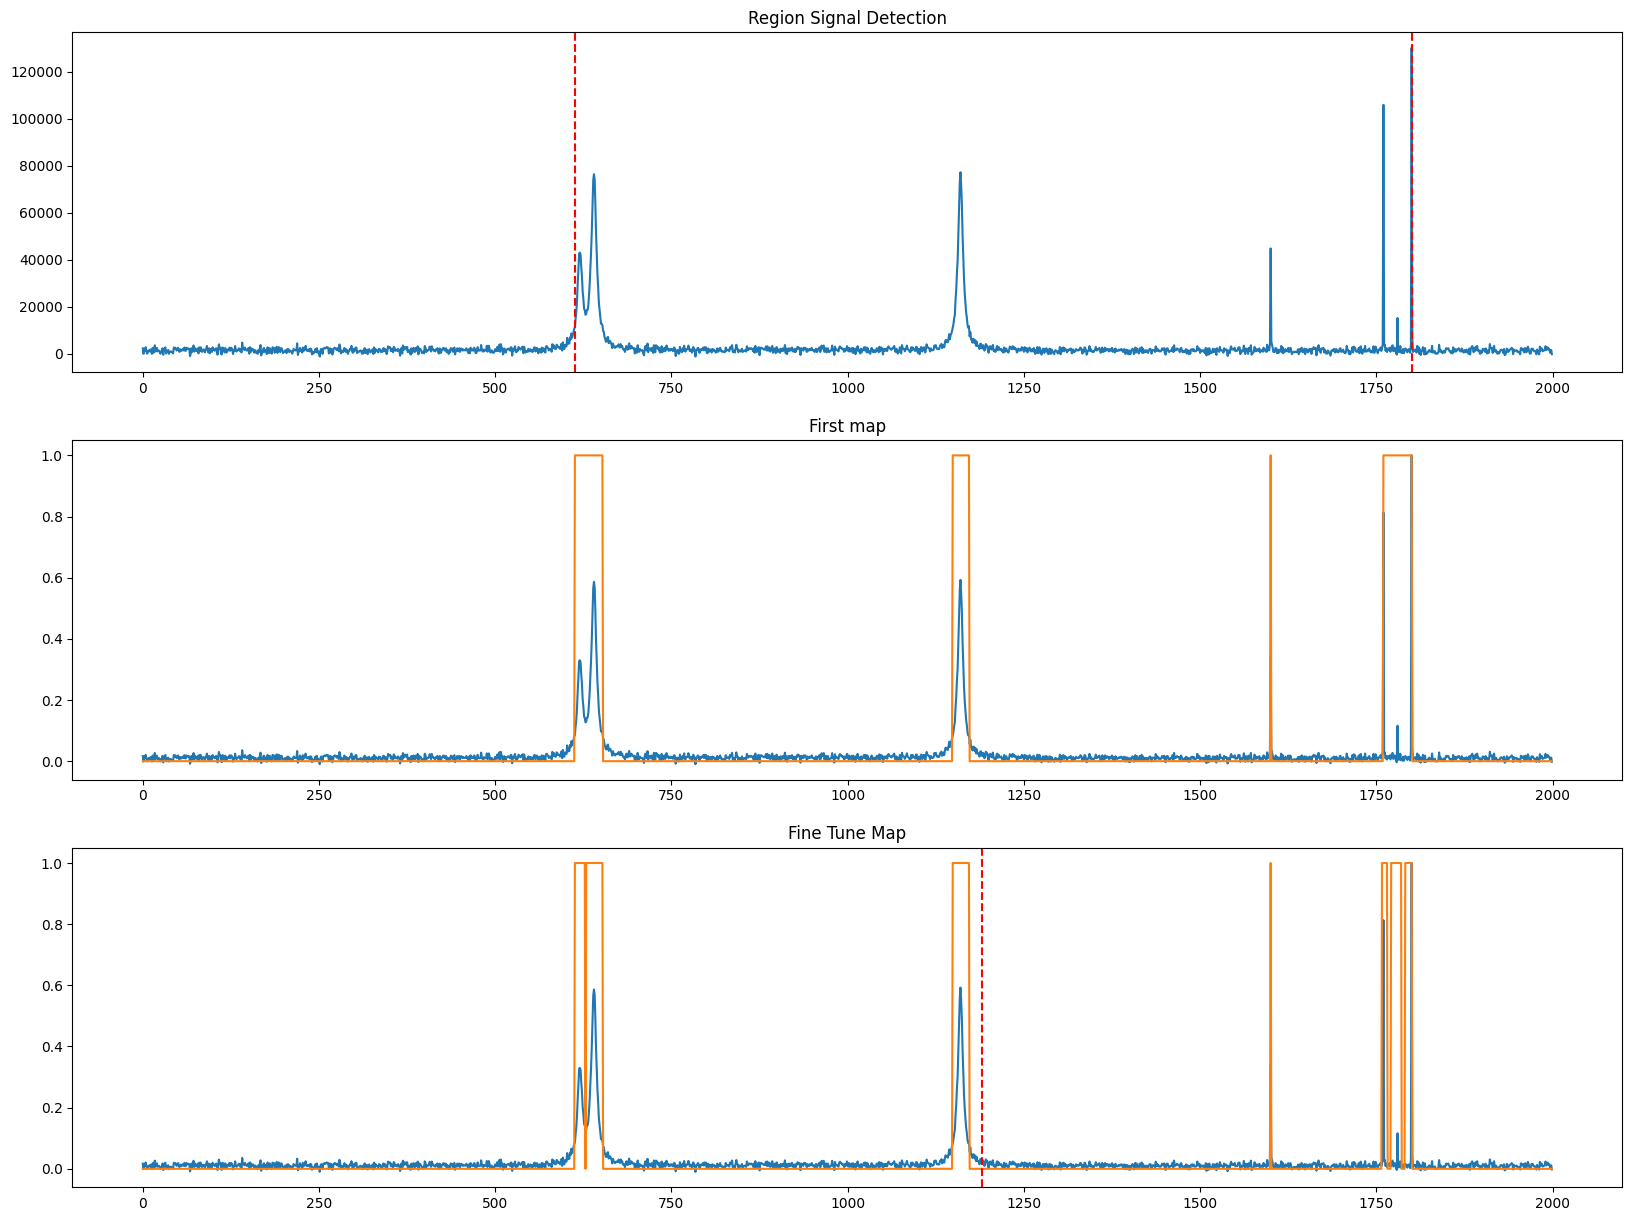

In [265]:
# Creazione del subplot
# Creazione del subplot
plt.figure(figsize=(20, 15))  # Imposta la dimensione della figura

# Primo subplot
plt.subplot(3, 1, 1)  # Numero di righe, numero di colonne, indice del subplot
plt.plot(signal)
plt.axvline(x=regionSgn[0], color='r', linestyle='--')
plt.axvline(x=regionSgn[-1], color='r', linestyle='--')
plt.title('Region Signal Detection')

# Secondo subplot
plt.subplot(3, 1, 2)
plt.plot(signal/max(signal))
plt.plot(first_map)
plt.title('First map')

# Terzo subplot
plt.subplot(3, 1, 3)
plt.plot(signal/max(signal))
plt.plot(new_map)
plt.title('Fine Tune Map')
plt.show()

In [266]:
def Denoising(signal,InfoBlock):
    denoised =[]
    sequense = []
    final_signal = np.copy(signal)
    for NumBlock in range(0,len(InfoBlock)):
        
        if NumBlock == 0: 

            sequense = final_signal[0: (InfoBlock[NumBlock]['Start']-1)]

            if len(sequense)>200: 
                layer = 200
            else: 
                layer = int(len(sequense))
            
            sample_noise = int(len(sequense)) # initial part of the signal where we only have noise
            denoiser = Denoiser()
            denoised = denoiser.denoise(sequense, layer)
            final_signal[ 0: (InfoBlock[NumBlock]['Start']-1)] = denoised 
            denoised = []
            sequense = []
            layer = []

        else: 
            if abs(((InfoBlock[NumBlock-1]['End']+1)-(InfoBlock[NumBlock]['Start']-1))) != 0: 
                sequense = final_signal[(InfoBlock[NumBlock-1]['End']+1):(InfoBlock[NumBlock]['Start']-1)]
                
                if len(sequense)>200: 
                    layer = 200
                else: 
                    layer = int(len(sequense))

                denoiser = Denoiser()
                denoised = denoiser.denoise(sequense,layer)
                final_signal[(InfoBlock[NumBlock-1]['End']+1):(InfoBlock[NumBlock]['Start']-1)] = denoised 
                denoised = []
                sequense = []
                layer = []


    sequense = final_signal[(InfoBlock[NumBlock]['End']+1):int(len(final_signal))]

    if len(sequense)>200: 
        layer = 200
    else: 
        layer = int(len(sequense))

    denoiser = Denoiser()
    denoised = denoiser.denoise(sequense, layer)
    final_signal[(InfoBlock[NumBlock]['End']+1):int(len(final_signal))] = denoised 

    return final_signal, sample_noise


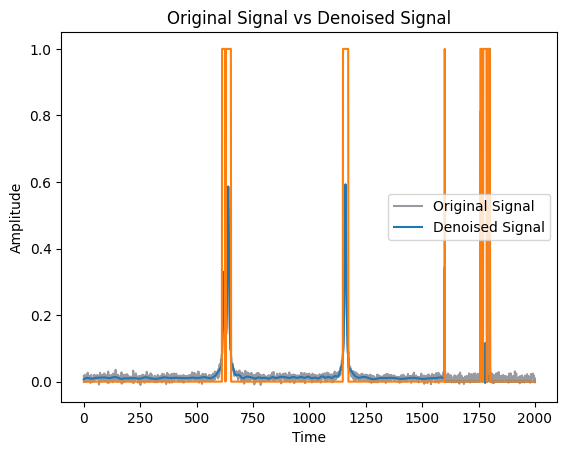

In [270]:
DenoisedSignal, Noise = Denoising(signal,InfoBlock)

# Plotting the original signal
plt.plot(signal/max(signal), color='#9999a1', label='Original Signal')

# Plotting the noisy signal on the same plot
plt.plot(DenoisedSignal/max(DenoisedSignal), label='Denoised Signal')
plt.plot(new_map)

# Adding labels and legend
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original Signal vs Denoised Signal')
plt.legend()

# Show the plot
plt.show()

In [271]:
# SNR before denoising 
std_noise = np.std(signal[0:Noise])
As = np.max(PeakVal)
SNR = 20 * np.log10(As/(4*std_noise))
SNR

28.904030926551517

In [272]:
# SNR after denoising 
std_noise = np.std(DenoisedSignal[0:Noise])
As = np.max(PeakVal)
SNR_after = 20 * np.log10(As/(4*std_noise))
SNR_after

33.94557608397513

In [273]:
SNR_after-SNR

5.0415451574236165

TESTS 


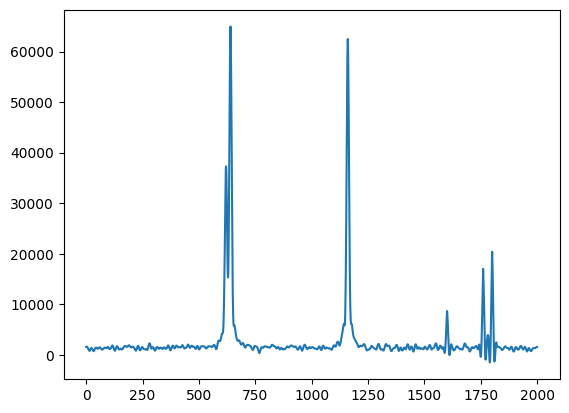

In [71]:
# try to apply denoising on all spectrum 
#!/usr/bin/env python3
# −*− coding:utf-8 −*−

import numpy as np
from scipy.linalg import svd


class Denoiser(object):
    '''
    A class for smoothing a noisy, real-valued data sequence by means of SVD of a partial circulant matrix.
    -----
    Attributes:
        mode: str
            Code running mode: "layman" or "expert".
            In the "layman" mode, the code autonomously tries to find the optimal denoised sequence.
            In the "expert" mode, a user has full control over it.
        s: 1D array of floats
            Singular values ordered decreasingly.
        U: 2D array of floats
            A set of left singular vectors as the columns.
        r: int
            Rank of the approximating matrix of the constructed partial circulant matrix from the sequence.
    '''

    def __init__(self, mode="layman"):
        '''
        Class initialization.
        -----
        Arguments:
            mode: str
                Denoising mode. To be selected from ["layman", "expert"]. Default is "layman".
                While "layman" grants the code autonomy, "expert" allows a user to experiment.
        -----
        Raises:
            ValueError
                If mode is neither "layman" nor "expert".
        '''
        self._method = {"layman": self._denoise_for_layman, "expert": self._denoise_for_expert}
        if mode not in self._method:
            raise ValueError("unknown mode '{:s}'!".format(mode))
        self.mode = mode

    def _embed(self, x, m): # 1) embeded the sequence into a matrix
        '''
        Embed a 1D array into a 2D partial circulant matrix by cyclic left-shift.
        -----
        Arguments:
            x: 1D array of floats
                Input array.
            m: int
                Number of rows of the constructed matrix.
        -----
        Returns:
            X: 2D array of floats
                Constructed partial circulant matrix.
        '''
        x_ext = np.hstack((x, x[:m-1]))
        shape = (m, x.size)
        strides = (x_ext.strides[0], x_ext.strides[0])
        X = np.lib.stride_tricks.as_strided(x_ext, shape, strides)
        return X

    def _reduce(self, A): # 7) application equation (10) -> cyclic antidiagonal averaging is applied to reconstruct the smoothed sequence a from A
        '''
        Reduce a 2D matrix to a 1D array by cyclic anti-diagonal average.
        -----
        Arguments:
            A: 2D array of floats
                Input matrix.
        -----
        Returns:
            a: 1D array of floats
                Output array.
        '''
        m = A.shape[0]
        A_ext = np.hstack((A[:,-m+1:], A))
        strides = (A_ext.strides[0]-A_ext.strides[1], A_ext.strides[1])
        a = np.mean(np.lib.stride_tricks.as_strided(A_ext[:,m-1:], A.shape, strides), axis=0)
        return a

    def _denoise_for_expert(self, sequence, layer, gap, rank):
        '''
        Smooth a noisy sequence by means of low-rank approximation of its corresponding partial circulant matrix.
        -----
        Arguments:
            sequence: 1D array of floats
                Data sequence to be denoised.
            layer: int
                Number of leading rows selected from the matrix.
            gap: float
                Gap between the data levels on the left and right ends of the sequence.
                A positive value means the right level is higher.
            rank: int
                Rank of the approximating matrix.
        -----
        Returns:
            denoised: 1D array of floats
                Smoothed sequence after denoise.
        -----
        Raises:
            AssertionError
                If condition 1 <= rank <= layer <= sequence.size cannot be fulfilled.
        '''
        assert 1 <= rank <= layer <= sequence.size
        self.r = rank
        # linear trend to be deducted
        trend = np.linspace(0, gap, sequence.size)
        X = self._embed(sequence-trend, layer)
        # singular value decomposition
        self.U, self.s, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)
        # low-rank approximation
        A = self.U[:,:self.r] @ np.diag(self.s[:self.r]) @ Vh[:self.r]
        denoised = self._reduce(A) + trend
        return denoised

    def _cross_validate(self, x, m):
        '''
        Check if the gap of boundary levels of the detrended sequence is within the estimated noise strength.
        -----
        Arguments:
            x: 1D array of floats
                Input array.
            m: int
                Number of rows of the constructed matrix.
        -----
        Returns:
            valid: bool
                Result of cross validation. True means the detrending procedure is valid.
        '''
        X = self._embed(x, m)
        self.U, self.s, self._Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False) # 2) apply SVD to X
        # Search for noise components using the normalized mean total variation of the left singular vectors as an indicator.
        # The procedure runs in batch of every 10 singular vectors.
        self.r = 0
        while True:
            U_sub = self.U[:,self.r:self.r+10]
            NMTV = np.mean(np.abs(np.diff(U_sub,axis=0)), axis=0) / (np.amax(U_sub,axis=0) - np.amin(U_sub,axis=0)) # 3) calculate the NMTVs
            try:
                # the threshold of 10% can in most cases discriminate noise components
                self.r += np.argwhere(NMTV > .1)[0,0]
                break
            except IndexError:
                self.r += 10
        # estimate the noise strength, while r marks the first noise component
        noise_stdev = np.sqrt(np.sum(self.s[self.r:]**2) / X.size)
        # estimate the gap of boundary levels after detrend
        gap = np.abs(x[-self._k:].mean()-x[:self._k].mean()) # 4) estimate the signal gap by averaging a few end-data in x
        valid = gap < noise_stdev  # if noise:stdev is smaller than delta, linearly detrend x, then repeat steps 2-4, otherwhise proceed
        return valid

    def _denoise_for_layman(self, sequence, layer):
        '''
        Similar to the "expert" method, except that denoising parameters are optimized autonomously.
        -----
        Arguments:
            sequence: 1D array of floats
                Data sequence to be denoised.
            layer: int
                Number of leading rows selected from the corresponding circulant matrix.
        -----
        Returns:
            denoised: 1D array of floats
                Smoothed sequence after denoise.
        -----
        Raises:
            AssertionError
                If condition 1 <= layer <= sequence.size cannot be fulfilled.
        '''
        assert 1 <= layer <= sequence.size
        # The code takes the mean of a few neighboring data to estimate the boundary levels of the sequence.
        # By default, this number is 11.
        self._k = 11
        # Initially, the code assumes no linear inclination.
        trend = np.zeros_like(sequence)
        # Iterate over the averaging length.
        # In the worst case, iteration must terminate when it is 1.
        while not self._cross_validate(sequence-trend, layer):
            self._k -= 2
            trend = np.linspace(0, sequence[-self._k:].mean()-sequence[:self._k].mean(), sequence.size)
        # low-rank approximation by using only signal components
        A = self.U[:,:self.r] @ np.diag(self.s[:self.r]) @ self._Vh[:self.r] # 6) build a low rank approximation A 
        denoised = self._reduce(A) + trend
        return denoised

    def denoise(self, *args, **kwargs):
        '''
        User interface method.
        It will reference to different denoising methods ad hoc under the fixed name.
        '''
        return self._method[self.mode](*args, **kwargs)
    
   
sequence = signal
denoiser = Denoiser()
denoised = denoiser.denoise(sequence,21)

plt.plot(denoised)

In [84]:
def _embed(x, m): # 1) embeded the sequence into a matrix
    '''
    Embed a 1D array into a 2D partial circulant matrix by cyclic left-shift.
    -----
    Arguments:
        x: 1D array of floats
            Input array.
        m: int
            Number of rows of the constructed matrix.
    -----
    Returns:
        X: 2D array of floats
            Constructed partial circulant matrix.
    '''
    x_ext = np.hstack((x, x[:m-1]))
    shape = (m, x.size)
    strides = (x_ext.strides[0], x_ext.strides[0])
    X = np.lib.stride_tricks.as_strided(x_ext, shape, strides)
    return X

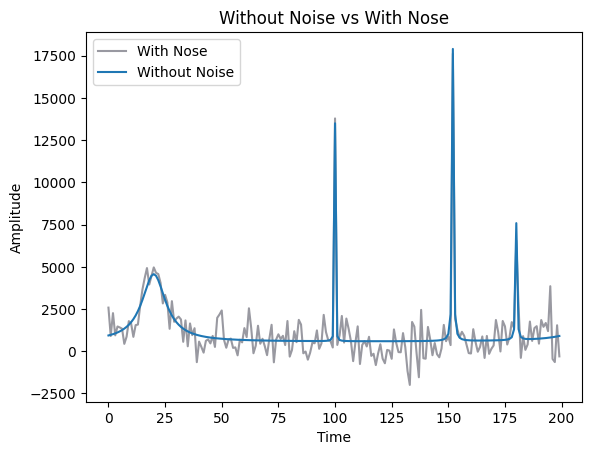

In [85]:
# Sinteti Data 

# Data generation 
t = np.arange(0, 2, 0.01)

fid1 = 100*np.exp(-t / 2.1) * np.cos(2 * np.pi * 50 * t) + 100*1j*np.exp(-t / 2.1) * np.sin(2 * np.pi * 50 * t)
fid2 = 800*np.exp(-t / 0.05) * np.cos(2 * np.pi * 10 * t) + 800*1j*np.exp(-t /  0.05) * np.sin(2 * np.pi * 10 * t)
fid3 =  80*np.exp(-t / 1) * np.cos(2 * np.pi * 90 * t) + 80*1j*np.exp(-t / 1) * np.sin(2 * np.pi * 90* t)
fid4 =  200*np.exp(-t / 1) * np.cos(2 * np.pi * 76 * t) + 200*1j*np.exp(-t / 1) * np.sin(2 * np.pi * 76 * t)


fid = fid1 + fid2 + fid3 +fid4

dt = t[2] - t[1] 
N = len(fid)
freqs = fftfreq(N, dt)

pure = np.real(fft(fid))
noise = np.random.normal(0,  200, len(pure))  # Generation Gaussian noise

signal = pure + 4 * noise          # Application noise to the pure sample

# Plotting the noisy signal on the same plot
plt.plot(signal, color = '#9999a1', label='With Nose')
# Plotting the original signal
plt.plot(pure, label='Without Noise')


# Adding labels and legend
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Without Noise vs With Nose')
plt.legend()

# Show the plot
plt.show()

In [362]:
# Assuming `_embed` and `pure` are defined elsewhere
k = 0.4
m = int(k * len(signal))
X = _embed(signal, m)
U_noisy, s_noisy, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)

m = int(k * len(pure))
X = _embed(pure, m)
U_pure, s_pure, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)

m = int(k * len(noise))
X = _embed(noise,m )
U_noise, s_noise, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)

# Create index for each singular value
index_noisy = np.arange(len(s_noisy))
index_pure = np.arange(len(s_pure))
index_noise = np.arange(len(s_noise))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#168aad'] * m  # Default color for all bars
colors[3:] = ['#52b69a'] * (m - 2)  # Color from the third bar to the end in green


# Bar plot of singular values
axs[0].bar(index_noisy, s_noisy, color = colors)
axs[0].set_title('signal + noise')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Box plot of singular values
axs[1].bar(index_pure, s_pure, color= ['#168aad'])
axs[1].set_title('signal')
axs[1].set_ylabel('Value')

# Plot of cumulative sum of singular values
axs[2].bar(index_noise, s_noise, color = ['#b5e48c'])
axs[2].set_title('noise')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Cumulative Sum')

plt.tight_layout()
plt.show()

In [275]:
r=0
while True:
    U_sub = U_noisy[:,r:r+10]
    NMTV = np.mean(np.abs(np.diff(U_sub,axis=0)), axis=0) / (np.amax(U_sub,axis=0) - np.amin(U_sub,axis=0)) # 3) calculate the NMTVs
    try:
        # the threshold of 10% can in most cases discriminate noise components
        r += np.argwhere(NMTV > .1)[0,0]
        break
    except IndexError:
       r += 10



0

Example with a sinc function

In [82]:
x = np.linspace(-10, 10, 100)
pure = np.sinc(x)
noise = np.random.normal(scale=.1, size=100)
signal = pure + noise

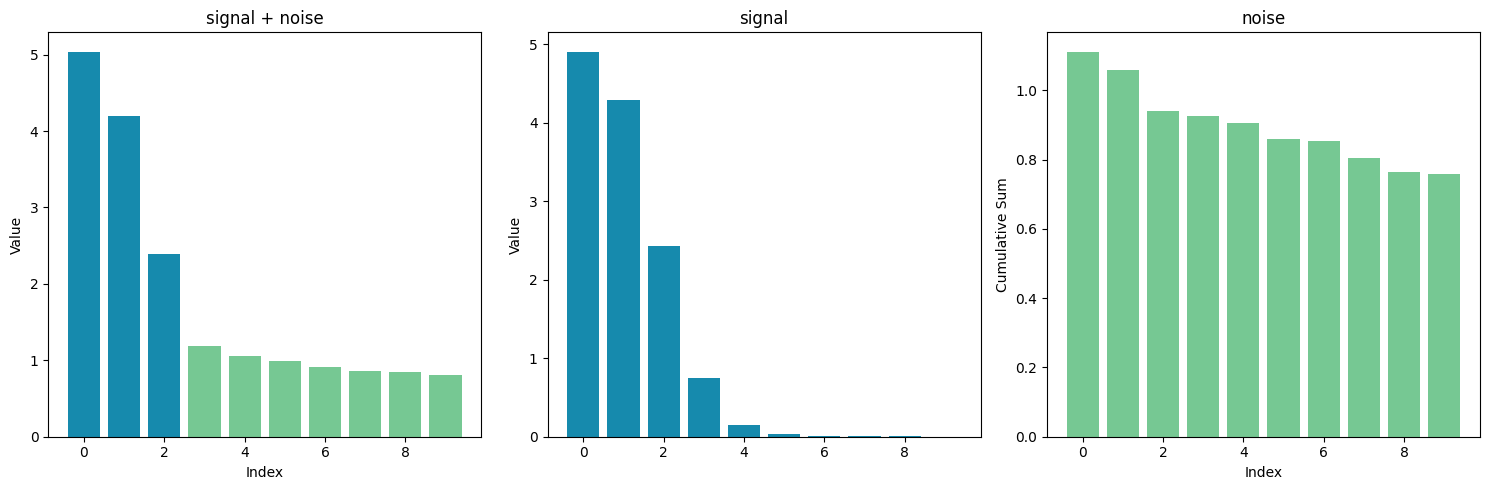

In [83]:
# Assuming `_embed` and `pure` are defined elsewhere
m = int(0.1 * len(signal))
X = _embed(signal, m)
U_noisy, s_noisy, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)

m = int(0.1 * len(pure))
X = _embed(pure, m)
U_pure, s_pure, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)

m = int(0.1 * len(noise))
X = _embed(noise,m )
U_noise, s_noise, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)

# Create index for each singular value
index_noisy = np.arange(len(s_noisy))
index_pure = np.arange(len(s_pure))
index_noise = np.arange(len(s_noise))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#168aad'] * m  # Default color for all bars
colors[3:] = ['#76c893'] * (m - 2)  # Color from the third bar to the end in green


# Bar plot of singular values
axs[0].bar(index_noisy, s_noisy, color=colors)
axs[0].set_title('signal + noise')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Box plot of singular values
axs[1].bar(index_pure, s_pure, color= ['#168aad'])
axs[1].set_title('signal')
axs[1].set_ylabel('Value')

# Plot of cumulative sum of singular values
axs[2].bar(index_noise, s_noise, color = ['#76c893'])
axs[2].set_title('noise')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Cumulative Sum')

plt.tight_layout()
plt.show()


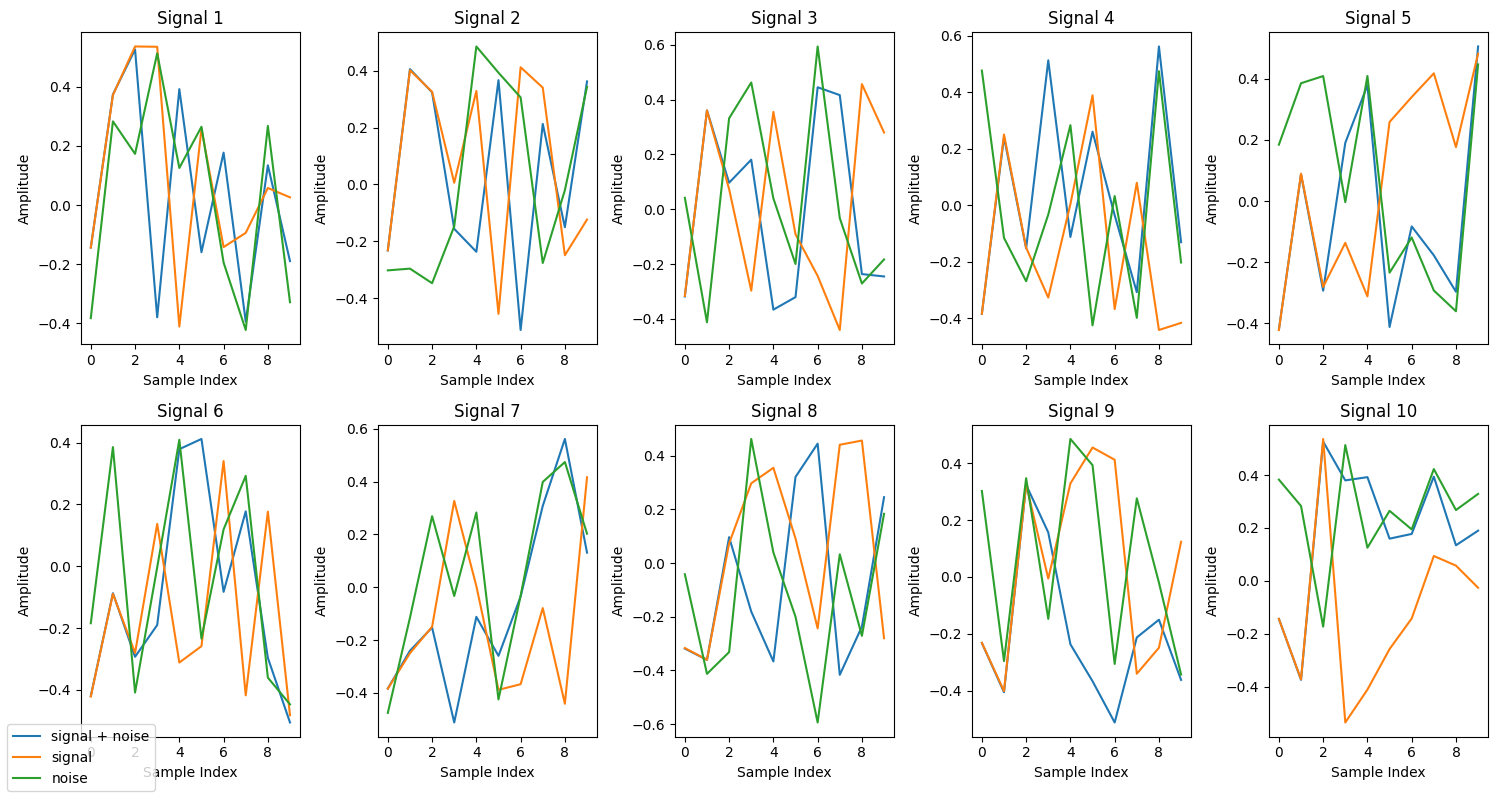

In [231]:
# Assuming U_noisy is a 2D array containing the signals
# Each row corresponds to a signal
num_signals = 10
num_samples = len(U_noisy[0])  # Assuming all signals have the same length

# Calcola il numero di righe e colonne necessarie per visualizzare tutti i segnali
num_rows = 2  # Puoi regolare questo valore a seconda delle tue preferenze
num_cols = int(np.ceil(num_signals / num_rows))

# Crea un unico plot con il layout desiderato
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Disegna ciascun segnale in un rettangolo
for i in range(num_signals):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].plot(np.arange(num_samples), U_noisy[i], label='signal + noise')
    # axs[row, col].plot(np.arange(num_samples), U_pure[i], label='signal')
    # axs[row, col].plot(np.arange(num_samples), U_noise[i], label='noise')
    axs[row, col].set_title('Signal {}'.format(i+1))
    axs[row, col].set_xlabel('Sample Index')
    axs[row, col].set_ylabel('Amplitude')

# Create a legend for the entire figure
fig.legend(['signal + noise', 'signal', 'noise'], loc='lower left')

# Rimuovi gli assi vuoti
for i in range(num_signals, num_rows*num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

TEST AGAIN WITH SIGNAL 


In [77]:
# Data generation 
t = np.arange(0, 2, 0.001)

fid1 = 100*np.exp(-t / 2.1) * np.cos(2 * np.pi * -100 * t) + 100*1j*np.exp(-t / 2.1) * np.sin(2 * np.pi * -100 * t)
fid2 = 10*np.exp(-t / 2.1) * np.cos(2 * np.pi * -110 * t) + 10*1j*np.exp(-t / 2.1) * np.sin(2 * np.pi * -110 * t)
fid9 =  80*np.exp(-t / 2.1) * np.cos(2 * np.pi * -120 * t) + 80*1j*np.exp(-t / 2.1) * np.sin(2 * np.pi * -120 * t)
# fid2 = 1000*np.exp(-t / 0.01) * np.cos(2 * np.pi * -800 * t) + 1000*1j*np.exp(-t / 0.01) * np.sin(2 * np.pi * -800 * t)
fid3 = 500*np.exp(-t / 0.08) * np.cos(2 * np.pi * 310 * t) + 500*1j*np.exp(-t / 0.08) * np.sin(2 * np.pi * 310 * t)
fid4 = +1000*np.exp(-t / 0.075) * np.cos(2 * np.pi * 320* t) + 1000*1j*np.exp(-t / 0.075) * np.sin(2 * np.pi * 320 * t)

fid5 = +50*np.exp(-t / 1) * np.cos(2 * np.pi * -200 * t) + 50*1j*np.exp(-t / 1) * np.sin(2 * np.pi * -200 * t)
fid6 = 1000*np.exp(-t / 0.075) * np.cos(2 * np.pi * -420* t) + 1000*1j*np.exp(-t / 0.075) * np.sin(2 * np.pi * -420 * t)


fid = fid1+fid2+fid3+fid4+fid5+fid6+fid9

dt = t[2] - t[1] 
N = len(fid)
freqs = fftfreq(N, dt)

pure = np.real(fft(fid))
noise = np.random.normal(0,  300, len(pure))  # Generation Gaussian noise

signal = pure + 3*noise          # Application noise to the pure sample

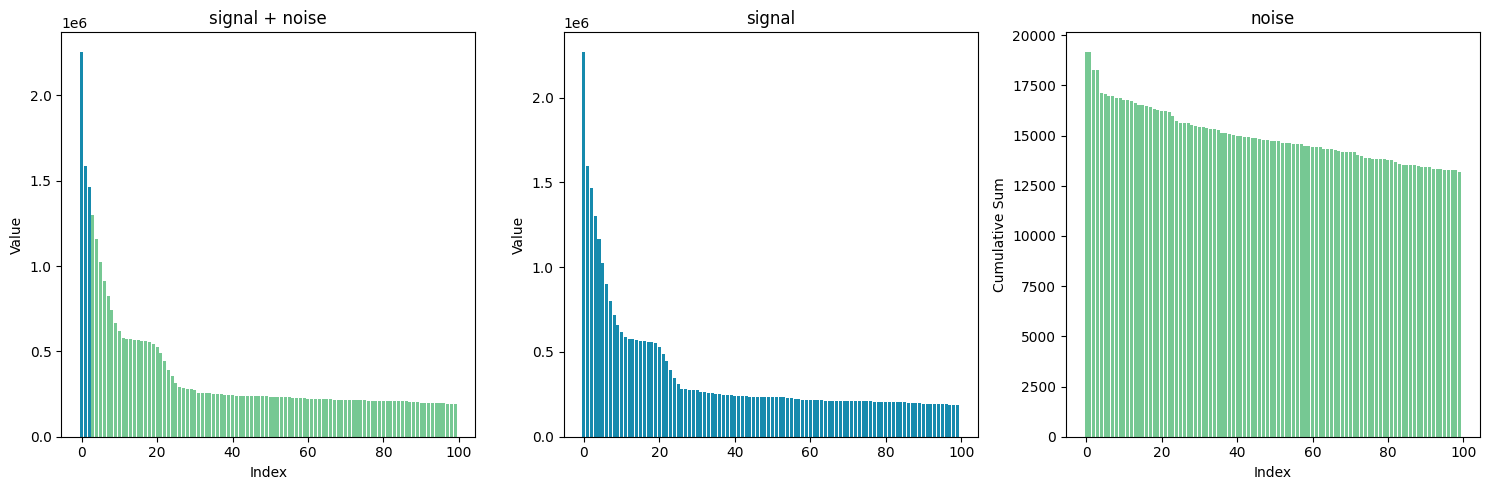

In [80]:
# Assuming `_embed` and `pure` are defined elsewhere
m = int(0.1 * len(signal))
X = _embed(signal, m)
U_noisy, s_noisy, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)

m = int(0.1 * len(pure))
X = _embed(pure, m)
U_pure, s_pure, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)

m = int(0.1 * len(noise))
X = _embed(noise,m )
U_noise, s_noise, Vh = svd(X, full_matrices=False, overwrite_a=True, check_finite=False)

# Create index for each singular value
index_noisy = np.arange(len(s_noisy))
index_pure = np.arange(len(s_pure))
index_noise = np.arange(len(s_noise))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#168aad'] * m  # Default color for all bars
colors[3:] = ['#76c893'] * (m - 2)  # Color from the third bar to the end in green


# Bar plot of singular values
axs[0].bar(index_noisy[0:100], s_noisy[0:100], color=colors)
axs[0].set_title('signal + noise')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Box plot of singular values
axs[1].bar(index_pure[0:100], s_pure[0:100], color= ['#168aad'])
axs[1].set_title('signal')
axs[1].set_ylabel('Value')

# Plot of cumulative sum of singular values
axs[2].bar(index_noise[0:100], s_noise[0:100], color = ['#76c893'])
axs[2].set_title('noise')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Cumulative Sum')

plt.tight_layout()
plt.show()

Creation Interacted Algorithm

In [87]:
new_map= process_blocks(map, signal, threshold_noise, buff_size=5)

In [103]:
from ipywidgets import interact, widgets, fixed, interactive, HBox, Layout

In [119]:
threshold_noise = 0
threshold

NameError: name 'threshold' is not defined

In [128]:
mm=interact(
        process_blocks,
        map =fixed(first_map),
        noisy_sgn =fixed(signal),
        th=widgets.FloatSlider(min=0, max=20*1000, step=0.00001, value=0, layout=Layout(width='1000px')),
        buff_size=widgets.IntSlider(min=0, max=100, step=1, value=0, layout=Layout(width='1000px')))
        # zoomT= widgets.IntSlider(min=1, max=100, step=1, value=0, layout=Layout(width='1000px')),
        # zoomL= widgets.IntSlider(min=0, max=len(freq), step=1, value=0, layout=Layout(width='1000px')),
        # zoomR= widgets.IntSlider(min=0, max=len(freq), step=1, value=0, layout=Layout(width='1000px')))

interactive(children=(FloatSlider(value=0.0, description='th', layout=Layout(width='1000px'), max=20000.0, ste…